## Importing standard libaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading in dataset for checking templates

In [ ]:
from tensorflow.keras.datasets import cifar10

# Loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Data Inspection Template

In [ ]:
import tensorflow as tf
from collections import Counter

def inspect_image_dataset(X, y=None, num_samples=9, dataset_name='Dataset'):
  '''
  Inspects the image dataset, displaying important statistics and sample images while returning import values for model creation later.

  Parameters:
    X: np.array, tf.data.Dataset, or list of images, The image dataset to inspect.
    y: np.array or list (optional), The labels corresponding to the images.
    num_samples: Type:int, (Default=9), Number of images to display.
    dataset_name: Type:str, (Default="Dataset"), Name of the dataset for display purposes.

  Returns:
    input_shape: Type:tuple, Shape of a single image.
    num_classes: Tyep:int, (if y is provided), Number of unique classes.
    is_grayscale: Whether the dataset contains grayscale images.
  '''

  # Converting TensorFlow dataset to numpy if needed
  if isinstance(X, tf.data.Dataset):
    X = np.array([img.numpy() for img in X])

  # Checking the dataset shape
  print(f'Dataset: {dataset_name}')
  print(f'Number of images: {len(X)}')

  # Checking input shape
  sample_image = X[0]
  input_shape = sample_image.shape
  print(f'Image Shape: {input_shape}')

  # Checking if images are grayscale
  is_grayscale = len(input_shape) == 2 or (len(input_shape) == 3 and input_shape[-1] == 1)
  print(f'Grayscale: {'Yes' if is_grayscale else 'No (RGB)'}')

  # Checking number of classes if labels are provided
  num_classes = None
  if y is not None:
    # Flattening the labels to ensure it's 1D
    y = y.ravel()

    unique_classes = np.unique(y)
    num_classes = len(unique_classes)
    print(f'Number of Classes: {num_classes}')

    # Showing class distribution
    plt.figure(figsize=(6, 3))
    sns.countplot(x=y, palette='viridis')
    plt.title(f'Label Distribution in {dataset_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

  # Displaying sample images
  plt.figure(figsize=(8, 8))
  for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image if is_grayscale else X[i])
    plt.axis('off')
    plt.title(f'Sample {i+1}')
  plt.suptitle(f'Sample Images from {dataset_name}')
  plt.show()

  return input_shape, num_classes, is_grayscale

### Testing the Inspection Template

Dataset: CIFAR-10
Number of images: 50000
Image Shape: (32, 32, 3)
Grayscale: No (RGB)
Number of Classes: 10


<ipython-input-9-55be1b42284c>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


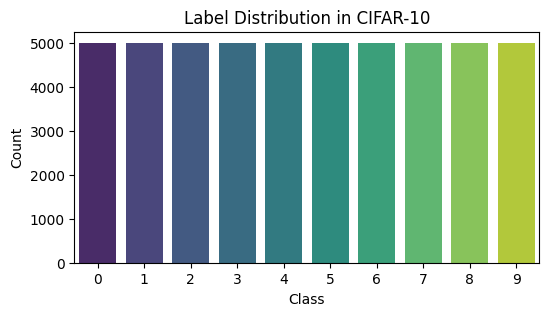

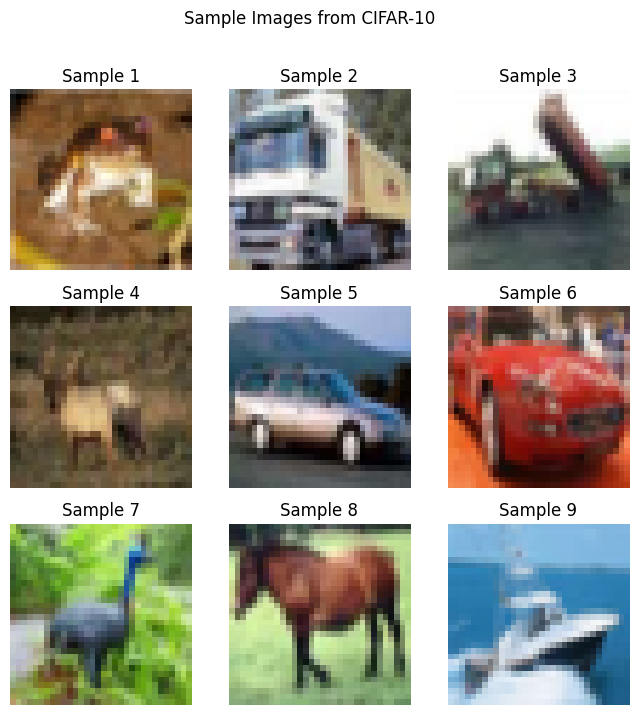

In [ ]:
# Inspecting the dataset
input_shape, num_classes, is_grayscale = inspect_image_dataset(X_train, y_train, dataset_name="CIFAR-10")

## General Image Preprocessing Template

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def preprocess_images(X, y=None, normalize=True, one_hot_encode=True, convert_rgb=False, target_shape=None, num_classes=None):
  '''
  Preprocesses an image dataset by normalizing pixel values, reshaping images and one hot encoding labels so that is it ready to be passed into a model.

  Parameters:
    X: np.array or list, The image dataset.
    y: np.array or list (optional), The labels corresponding to the images.
    normalize: Default=True, Whether to normalize pixel values to [0,1].
    one_hot_encode: Default=True, Whether to one-hot encode labels.
    convert_rgb: Default=False, Convert grayscale images to RGB.
    target_shape: Default=None, If specified, reshapes images to this size.
    num_classes: Type-int, Default=None, Required if one-hot encoding labels.

  Returns:
    X: Preprocessed image dataset.
    y: Processed labels (one-hot encoded if enabled)
  '''

  # Converting X to numpy array if it's not
  X = np.array(X)

  # Normalizing pixel values
  if normalize:
    X = X.astype('float32') / 255.0

  # Converting grayscale to RGB if required
  if convert_rgb and X.shape[-1] == 1:
    X = np.repeat(X, 3, axis=-1)  # Converting 1-channel grayscale to 3-channel RGB

  # Reshaping images if target shape is provided
  if target_shape:
    X = np.array([tf.image.resize(img, target_shape).numpy() for img in X])

  # Process labels if provided
  if y is not None:
    y = np.array(y).ravel()  # Ensure labels are 1D

    # One-hot encode labels
    if one_hot_encode:
      if num_classes is None:
        raise ValueError("num_classes must be provided when one_hot_encode=True")
      y = to_categorical(y, num_classes=num_classes)

  return (X, y) if y is not None else X


### Testing Preprocessing Template

In [ ]:
# Preprocessing images
X_train_processed, y_train_processed = preprocess_images(
    X_train,
    y_train,
    target_shape=(32, 32), # input_shape returned by previous template
    num_classes=num_classes
)

# Checking new shape
print(f"Processed Image Shape: {X_train_processed.shape}")
print(f"Processed Label Shape: {y_train_processed.shape}")

Processed Image Shape: (50000, 32, 32, 3)
Processed Label Shape: (50000, 10)


## Data Augmentation Template

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(X, y=None, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, brightness_range=None, batch_size=32):
  '''
  Applies data augmentation to the to the image dataset increasing the variability of the images and reducing the chance of overfitting.

  Parameters:
    X: np.array, The image dataset.
    y: np.array (optional), The labels corresponding to the images.
    rotation_range: Default=20, Degree range for random rotations.
    width_shift_range: Default=0.2, Fraction of total width to shift.
    height_shift_range: Default=0.2, Fraction of total height to shift.
    zoom_range: Default=0.2, Range for random zoom.
    horizontal_flip: Default=True, Whether to randomly flip images horizontally.
    brightness_range: Default=None, Tuple (min, max) for brightness variation.
    batch_size: Default=32, Number of images generated per batch.

  ReturnsL
    datagen: Augmented data generator.
  '''

  datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    zoom_range=zoom_range,
    horizontal_flip=horizontal_flip,
    brightness_range=brightness_range
    )

  # Flowing from X and y (if labels exist)
  datagen = datagen.flow(X, y, batch_size=batch_size) if y is not None else datagen.flow(X, batch_size=batch_size)

  return datagen

### Testing the Data Augmenter

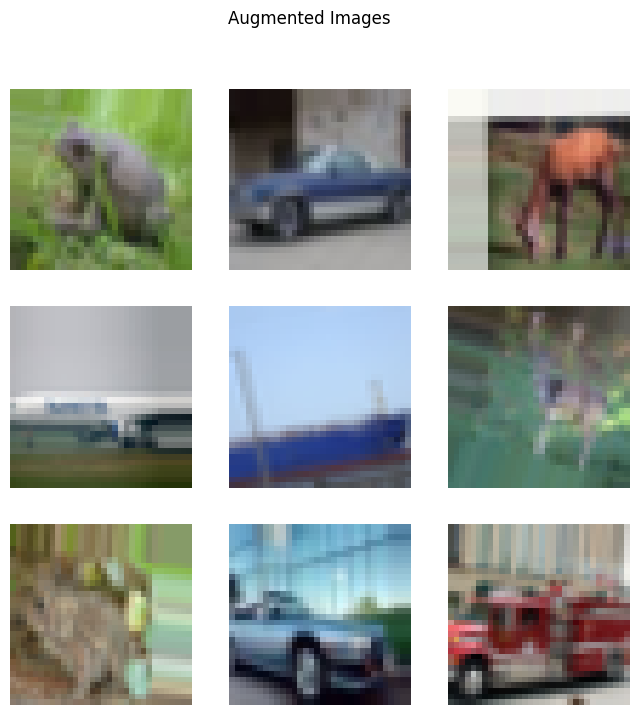

In [ ]:
# Applying augmentation
augmented_data = augment_images(X_train_processed, y_train_processed)

# Generating and displaying a few samples
# Extracting a batch of augmented images
X_augmented_batch, y_augmented_batch = next(augmented_data)

# Plotting the first 9 images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_augmented_batch[i])
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()

## Transfer Learning Template

In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2

def load_transfer_learning_model(base_model_name='VGG16', input_shape=(224, 224, 3)):
  '''
  Loads a pre-trained model for transfer learning, allowing customization of layer freezing.

  Parameters:
    base_model_name: Default='VGG16', Options - ('VGG16', 'ResNet50', 'MobileNetV2')
    input_shape: Default=(224,224,3), Input image shape.

  Info:
    input_shape:
      VGG16 & ResNet50 require 224x224. MobileNetV2 supports multiple sizes, e.g. (96, 96), (128, 128), (224, 224)

      VGG16 (Simple but Heavy):
        Deep but simple → A sequential stack of convolutional layers
        Good for smaller datasets
        Huge parameter count → ~138M parameters (large and slow)
        Prone to overfitting due to many parameters
        Use case: Best for transfer learning on small datasets, where a simple feature extractor works well.

      ResNet50 (Solves Vanishing Gradient):
        50 layers deep but uses Residual Connections (skip connections)
        Avoids vanishing gradients (a big issue in deep networks)
        More efficient than VGG16 (~25M parameters)
        Still large, but better performance than VGG16
        Use case: Best for more complex datasets, especially where deeper networks help.

      MobileNetV2 (Optimized for Speed & Mobile Use):
        Lightweight & efficient (~3.5M parameters!)
        Uses Depthwise Separable Convolutions to reduce computation
        Works great on mobile & embedded devices
        May not perform as well on large datasets
        Use case: Best for low-power applications or when speed is more important than extreme accuracy.

  Returns:
    model: The transfer learning model ready to be passed into a custom classifier.
  '''

  # Selecting base model
  base_model_dict = {
      'VGG16': VGG16,
      'ResNet50': ResNet50,
      'MobileNetV2': MobileNetV2
    }

  if base_model_name not in base_model_dict:
    raise ValueError(f'Invalid model name. Choose from {list(base_model_dict.keys())}')

  print(f'Loading {base_model_name} as the base model')

  # Loading the model without its classifier head
  base_model = base_model_dict[base_model_name](
    weights='imagenet',  # Using ImageNet pre-trained weights - Can change if required
    include_top=False,   # Exclude fully connected layers
    input_shape=input_shape
  )

  # Printing all layers for reference
  print('Model Layers:')
  for i, layer in enumerate(base_model.layers):
    print(f'{i}: {layer.name} - Trainable: {layer.trainable}')

  # Asking the user if they want to unfreeze layers
  while True:
    user_input = input('\nEnter the layer index from which you want to unfreeze (or type "None" to freeze all layers): ')

    if user_input.lower() == 'none':
      for layer in base_model.layers:
        layer.trainable = False
      print('\nAll layers are frozen.')
      break  # Exit loop

    elif user_input.isdigit() and 0 <= int(user_input) < len(base_model.layers):
      freeze_until = int(user_input)
      for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
      for layer in base_model.layers[freeze_until:]:
        layer.trainable = True
      print(f'\nLayers from index {freeze_until} onwards are now trainable.')
      break  # Exit loop

    else:
      print('Invalid input. Please enter a valid layer index or "None".')

    # Printing updated layer states
  print('\nUpdated Layer Freezing Status:')
  for i, layer in enumerate(base_model.layers):
    print(f'{i}: {layer.name} - Trainable: {layer.trainable}')

  print('\nModel is ready for custom classifier addition!')

  return base_model

### Testing the Transfer Learning Template

In [ ]:
# Load VGG16 and manually select which layers to unfreeze
base_model = load_transfer_learning_model(base_model_name='VGG16')

# Add a custom classifier on top of base_model later

Loading VGG16 as the base model
Model Layers:
0: input_layer_5 - Trainable: True
1: block1_conv1 - Trainable: True
2: block1_conv2 - Trainable: True
3: block1_pool - Trainable: True
4: block2_conv1 - Trainable: True
5: block2_conv2 - Trainable: True
6: block2_pool - Trainable: True
7: block3_conv1 - Trainable: True
8: block3_conv2 - Trainable: True
9: block3_conv3 - Trainable: True
10: block3_pool - Trainable: True
11: block4_conv1 - Trainable: True
12: block4_conv2 - Trainable: True
13: block4_conv3 - Trainable: True
14: block4_pool - Trainable: True
15: block5_conv1 - Trainable: True
16: block5_conv2 - Trainable: True
17: block5_conv3 - Trainable: True
18: block5_pool - Trainable: True

Enter the layer index from which you want to unfreeze (or type "None" to freeze all layers): 15

Layers from index 15 onwards are now trainable.

Updated Layer Freezing Status:
0: input_layer_5 - Trainable: False
1: block1_conv1 - Trainable: False
2: block1_conv2 - Trainable: False
3: block1_pool - Tr